In [1]:
#path = 'saved_model_1020_5class_combined_RMSprop_100_0.0001_ENCFRZ_False'
#path = 'saved_model_1020_RMSprop_100_0.0001_BNone_classweights_P3_S10_EncoderTrained'
#path = 'saved_model_1021_(960, 1152)_0.001'
#path = 'saved_model_1021_(960, 1152)_0.0005'
#path = 'saved_model_1026_(960, 1152)_0.001'
#path = 'saved_model_1027_(960, 1152)_0.001_ENC_True'
#path = 'saved_model_1027_(1200, 1392)_0.0001_ENC_False'
#path = 'saved_model_1028_(1200, 1392)_0.0001_ENC_False'
#path = 'saved_model_1029_(1200, 1392)_0.001_ENC_False_onechannel'
#path = 'saved_model_1101_(960, 1152)_0.001_ENC_False_RGB_False_ACC_0.991'
#path = 'saved_model_1102_(960, 1152)_0.0001_ENC_False_RGB_False_ACC_0.991_Brightness'
#path = 'saved_model_1103_(960, 1152)_0.0001_ENC_False_RGB_False_ACC_0.991_Bright_Imagenet'
#path = 'saved_model_1103_(960, 1152)_0.0001_ENC_False_RGB_False_ACC_0.991_Bright_Imagenet_resize'
#path = 'saved_model_1104_(960, 1152)_0.0001_ENC_False_RGB_False_ACC_0.991_Bright_Imagenet_resize'
#path = 'saved_model_1109_(960, 1152)_0.0001_RGB_False_ACC_0.992_Bright_Imagenet_resize'
path = 'saved_model_1111_(960, 1152)_RGB_False_ACC_0.988_3rd_data'

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from IPython.display import clear_output
import matplotlib.pyplot as plt

#import segmentation_models as sm

import numpy as np
from numpy import genfromtxt
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

import glob
import cv2
import gc

from tqdm import tqdm
import time

2.2.0


In [3]:
"""
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [179]:
#import shutil
#shutil.unpack_archive('Raw.zip')


In [3]:
IMG_SIZE = (960, 1152) #1200, 1392  960, 1152

In [4]:
def display(display_list, idx=None, loc='.', name='label', only_inference=False, 
            fig_size=15, title=['Ground Truth Mask', 'Pushed', 'Stamped'],gray=True):
    """
    "only_inference" = True creates sample of inferenced image PNG file.
    """
    if only_inference:
        for lab,i in enumerate(range(len(display_list))):
            a = np.array(display_list[i])
            a = a.astype(np.float32) * 255.0

            plt.imshow(tf.keras.preprocessing.image.array_to_img(a))
            cv2.imwrite(loc+"/Image{}".format(idx)+"_{}{}.png".format(name,lab+1), cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
    
    else:
        plt.figure(figsize=(fig_size,fig_size))
        #title = ['Ground Truth Mask', 'Pushed', 'Stamped', 'hole']

        for i in range(len(display_list)):
            if i == 0 and gray:
                COLOR = 'gray'
            else:
                COLOR = None
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = COLOR)
            plt.axis('off')

        plt.show()
    

In [5]:
def create_mask(pred_mask, num=0):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
    if test_mode:
        print("In testing Mode...")
        for i in range(num):
            pred_mask = model.predict(x, batch_size=1)
            display([x[i], y[i], create_mask(pred_mask, num=i)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [6]:
def draw_and_count(img, contours, label = '', draw_type = 'contour', show=True):
    # img : original image
    # contours: Contours found from opencv code
    assert label in ['push', 'stamp', 'hole'], "label must be either 'push' or 'stamp'"
    assert draw_type in ['bbox', 'contour'], "draw type must be either 'bbox' or 'contour'"
    
    if label=='push': val = 220
    if label=='stamp': val = 150
    if label=='hole': val = 250
        
        
    count = 0
    area = []
    width_height = []
    
    for idx, cnt in enumerate(contours):
        a = cv2.contourArea(cnt)
        if a < val:
            continue
        
        area.append(a)
        count += 1
        
        if draw_type == 'bbox':
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(125,125,0),2)
            width_height.append([w,h])
            print("{} #{} has width of {} and height of {}".format(label, idx, w, h))
            
        elif draw_type == 'contour':
            cv2.drawContours(img, [cnt], 0, (125, 125, 0), 2) 
            
    if show:        
        display([img], fig_size=8)
        print("{} {} found. Area: {}".format(count,label,area))

        
    return img, area, width_height, count

{0: [0.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 1.0, 1.0], 3: [1, 1, 0], 4: [1.0, 0.23529411764705882, 0.23529411764705882], 5: [1.0, 0.5490196078431373, 0.0], 6: [0.23137254901960785, 0.23137254901960785, 1.0]}


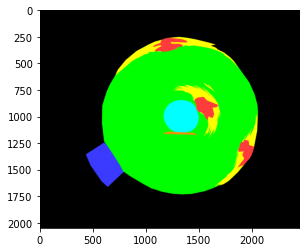

In [7]:
import cv2
from itertools import product

loc = "../../data/LGES_Vision/JR_Bottom/0.Data/211110_3rd_data/"

mask = cv2.imread(loc + 'Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) / 255.0

cc = cv2.inRange(mask, (.99, 0, .99), (1,0,1))
mask[cc != 0] = [0,1,0]

colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

plt.imshow(mask)

color_dict = {i: list(x) for i,x in enumerate(colors)}

color_dict[6] = color_dict[3]
color_dict[3] = [1,1,0]

print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

# WITHOUT TRT

In [134]:
model = tf.keras.models.load_model(path,compile=False)

In [135]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 960, 1152, 1)]    0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 960, 1152, 3)      6         
_________________________________________________________________
model (Model)                (None, 960, 1152, 7)      2821415   
Total params: 2,821,421
Trainable params: 2,812,589
Non-trainable params: 8,832
_________________________________________________________________


In [318]:
"""
time_list = []
pred_mask = []

for idx,image in enumerate(tqdm(glob.glob("images/test/*.bmp"))):
    start = time.time()
    
    n = cv2.imread(image)
    n = tf.cast(n, tf.float32) / 255.0
    image = tf.image.resize(n, IMG_SIZE) 
    
    image = tf.expand_dims(image,0)
    pred_mask.append(model(image)) # N, H, W, 3
    
    ex = pred_mask[idx][0] # H,W,4
    
    pushed = np.round(tf.expand_dims(ex[:,:,1], -1)) + np.round(tf.expand_dims(ex[:,:,2], -1))
    circle = np.round(tf.expand_dims(ex[:,:,3], -1))
    stamped = np.round(tf.expand_dims(ex[:,:,2], -1))
    
    stamped_x = stamped.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed_stamp = cv2.dilate(stamped_x, k)
    contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    stamp_img, stamp_area, wh, stamp_count = draw_and_count(stamped_x, contours, label='stamp', show=False)
    
    pushed_x = pushed.astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
    closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    push_img, push_area, wh, pushed_count = draw_and_count(pushed_x, contours, label='push', show=False)
    
    #print("Sample #{} has {} stamps and {} pushes. Stamp areas: {}, Push areas: {}".format(idx, stamp_count, pushed_count, 
    #                                                                                 stamp_area, push_area))
    
    time_list.append(time.time()-start)
    
print("Average inference time is: ", (np.mean(time_list) * 1000).round(3), "ms")
"""

100%|██████████| 46/46 [00:04<00:00, 10.30it/s]

Average inference time is:  96.475 ms


In [9]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

model = tf.saved_model.load(path, tags=[trt.tag_constants.SERVING])
graph_func = model.signatures[trt.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
frozen_func = trt.convert_to_constants.convert_variables_to_constants_v2(graph_func)

In [111]:
time_list = []
pred_mask = []
val_x = []
val_y = []

with open("Val_img.txt") as f:
    for idx,line in enumerate(f):
        img = line.splitlines()[0]
        
        n = cv2.imread(loc + "Original_Image/" + img, 0 ) # Gray Scale
        n = tf.expand_dims(n,-1)
        
        #n = cv2.imread("JR_lower_part/Original_Image/" + img)
        #n = cv2.cvtColor(cv2.imread("JR_lower_part/Original_Image/" + img,), cv2.COLOR_BGR2RGB) # Gray RGB
        
        n = tf.cast(n, tf.float32) / 255.0
        n = tf.image.resize(n, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        val_x.append(n)
        #MASK
        y = cv2.imread(loc + "Mask_Image/" + img) # imread(dir+file_name+".png")
        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB) / 255.0
        
        cc = cv2.inRange(y, (.99, 0, .99), (1,0,1))

        y[cc != 0] = [0,1,0]
        a = rgb_to_onehot(y, color_dict) #change to one hot

        bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
        mask = tf.image.resize(bb, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        val_y.append(mask)
        
        start = time.time()

        image = tf.expand_dims(n,0)
        pred_mask.append(frozen_func(image)) # idx, 1, 1, H, W, 4

        time_list.append(time.time()-start)
        if idx == 10: break
    
print("Average inference time is: ",(np.mean(time_list) * 1000).round(3), "ms")

val_x = tf.convert_to_tensor(val_x)
val_y = tf.convert_to_tensor(val_y)

Average inference time is:  6.225 ms


In [164]:
pred_mask = []
val_x = []

img_dir = 'Raw/*.bmp' # "2021-11-01-09/*.bmp" 

for img in glob.glob (img_dir):
    n = cv2.imread(img, 0) # Gray Scale
    n = tf.expand_dims(n,-1)
    #n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB) # Gray RGB
    #n = tf.expand_dims(n,-1) #Gray Scale

    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE, antialias = True, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    val_x.append(n)
    #MASK

    image = tf.expand_dims(n,0)
    pred_mask.append(frozen_func(image)) # idx, 1, 1, H, W, 4

val_x = tf.convert_to_tensor(val_x)

In [109]:
"""
gc.collect()

train_x = []
train_y = []

for img in glob.glob("JR_lower_part/Original_Image/*.png"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE) #960,1152
    #n = tf.image.rgb_to_grayscale(n)

    n = tf.image.flip_left_right(n)

    train_x.append(n)
    
    dir = "JR_lower_part/Mask_Image/" # "/".join(img.split("/")[:-1]) + "/Mask_Image/"
    file_name = img.split("/")[-1] # img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name) # imread(dir+file_name+".png")
    
    cc = cv2.inRange(y, (.99, 0, .99), (1,0,1))
    y[cc != 0] = [0,1,0]
    
    #dir = "/".join(img.split("/")[:-1]) + "/new_gt_mask/"
    #file_name = img.split("/")[-1].split('.')[0]

    #y = cv2.imread(dir+file_name+".png")

    a = rgb_to_onehot(y, color_dict) #change to one hot
    
    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot #0,1,2,3
    bbb = tf.image.resize(bb, IMG_SIZE) #960,1152
    
    bbb = tf.image.flip_left_right(bbb)

    train_y.append(bbb)

test_x = tf.convert_to_tensor(train_x)
test_y = tf.convert_to_tensor(train_y)

print(test_x.shape)
print(test_y.shape)
"""

(80, 1200, 1392, 3)
(80, 1200, 1392, 1)


Ground truth numbers:
1.   black_ng:
1, 2/1, 3, 4, 4/2, 4/2, 3/1, 1, 1, 4/1
3/3, 2, 4/1, 3/1
2.   silver_ng:
4, 4/1, 4/2, 3/1, 1, 1/1, 4/1,
3/2, 2, 4, 2/1




In [13]:
"""
np.savez_compressed('test_img_array', test_0 = np.float32(pred_mask[0][0][0]), test_1 = np.float32(pred_mask[1][0][0]), 
                   test_2 = np.float32(pred_mask[2][0][0]), test_3 = np.float32(pred_mask[3][0][0]))
"""

"\nnp.savez_compressed('test_img_array', test_0 = np.float32(pred_mask[0][0][0]), test_1 = np.float32(pred_mask[1][0][0]), \n                   test_2 = np.float32(pred_mask[2][0][0]), test_3 = np.float32(pred_mask[3][0][0]))\n"

In [13]:
print(val_x.shape[0])

20


In [11]:
def onehot_to_rgb(one_hot, label = None):
    #0 bg 1 circle 2 hole 3push 4stamped

    channel_0 = np.zeros(IMG_SIZE + (1,)) #prediction
    channel_1 = np.zeros(IMG_SIZE + (1,))
    channel_2 = np.zeros(IMG_SIZE + (1,))
    
    ex = one_hot # ex = H,W,1

    #pushed = tf.expand_dims(ex[:,:,1], -1) + tf.expand_dims(ex[:,:,2], -1)
    #circle = tf.expand_dims(ex[:,:,3], -1)
    #stamped = tf.expand_dims(ex[:,:,2], -1) # stamped = H,W,1
    #bg = tf.expand_dims(ex[:,:,0], -1)
    #hole = tf.expand_dims(ex[:,:,4], -1)
    
    if label:
        channel_0[ex==1] = color_dict[label][0]
        channel_1[ex==1] = color_dict[label][1]
        channel_2[ex==1] = color_dict[label][2]
        com = tf.concat([channel_0, channel_1, channel_2], -1)
        return com

    channel_0[ex==1] = color_dict[1][0]
    channel_1[ex==1] = color_dict[1][1]
    channel_2[ex==1] = color_dict[1][2]

    channel_0[ex==3] = color_dict[3][0]
    channel_1[ex==3] = color_dict[3][1]
    channel_2[ex==3] = color_dict[3][2]

    channel_0[ex==2] = color_dict[2][0]
    channel_1[ex==2] = color_dict[2][1]
    channel_2[ex==2] = color_dict[2][2]

    channel_0[ex==0] = color_dict[0][0]
    channel_1[ex==0] = color_dict[0][1]
    channel_2[ex==0] = color_dict[0][2]
    
    channel_0[ex==4] = color_dict[4][0]
    channel_1[ex==4] = color_dict[4][1]
    channel_2[ex==4] = color_dict[4][2]
    
    channel_0[ex==5] = color_dict[5][0]
    channel_1[ex==5] = color_dict[5][1]
    channel_2[ex==5] = color_dict[5][2]
    
    channel_0[ex==6] = color_dict[6][0]
    channel_1[ex==6] = color_dict[6][1]
    channel_2[ex==6] = color_dict[6][2]
    

    com = tf.concat([channel_0, channel_1, channel_2], -1)
    
    return com

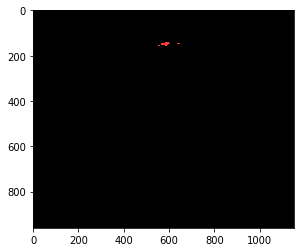

In [415]:
"""
NUM_IMGS = val_x.shape[0]

for idx in range(10):
    pred = np.float32(pred_mask[idx][0][0])

    ex = np.round(pred) # ex = H,W,5
    # 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

    circle = tf.expand_dims(ex[:,:,1], -1)
    pushed = tf.expand_dims(ex[:,:,3], -1) 
    bg = tf.expand_dims(ex[:,:,0], -1)
    hole = tf.expand_dims(ex[:,:,2], -1)
    stamped = tf.expand_dims(ex[:,:,4], -1)

    #bg = 0, pushed = 1, stamped = 2, circle = 3

    #print((gt_mask==1).sum())

    display([onehot_to_rgb(circle,label=1), onehot_to_rgb(hole,label=2), 
             onehot_to_rgb(pushed,label=3), onehot_to_rgb(stamped, label=4)], loc = 'test_images/validation/label_class',
            fig_size=20, idx=idx, only_inference=True, title=['circle', 'hole','push','stamp'], gray= False)
"""

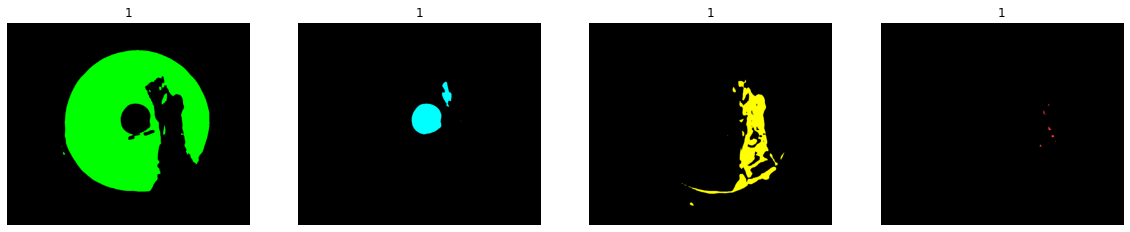

In [193]:
idx=9

pred = np.float32(pred_mask[idx][0][0])

ex = np.round(pred) # ex = H,W,5
# 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

circle = tf.expand_dims(ex[:,:,1], -1)
pushed = tf.expand_dims(ex[:,:,3], -1) 
bg = tf.expand_dims(ex[:,:,0], -1)
hole = tf.expand_dims(ex[:,:,2], -1)
stamped = tf.expand_dims(ex[:,:,4], -1)
in_tab = tf.expand_dims(ex[:,:,5], -1)
out_tab = tf.expand_dims(ex[:,:,6], -1)


#bg = 0, pushed = 1, stamped = 2, circle = 3

#print((gt_mask==1).sum())

display([onehot_to_rgb(circle,label=1), onehot_to_rgb(hole,label=2), 
         onehot_to_rgb(pushed,label=3), onehot_to_rgb(stamped, label=4)], title=['1','1','1','1'],
        fig_size=20, gray= False)

In [194]:
""" NEEDED for 6 class?
mask = imread('Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448
colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)
orig_color_dict = {i: list(x) for i,x in enumerate(colors)}
"""

" NEEDED for 6 class?\nmask = imread('Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448\ncolors = np.unique(tf.reshape(mask,[-1,3]), axis=0)\norig_color_dict = {i: list(x) for i,x in enumerate(colors)}\n"

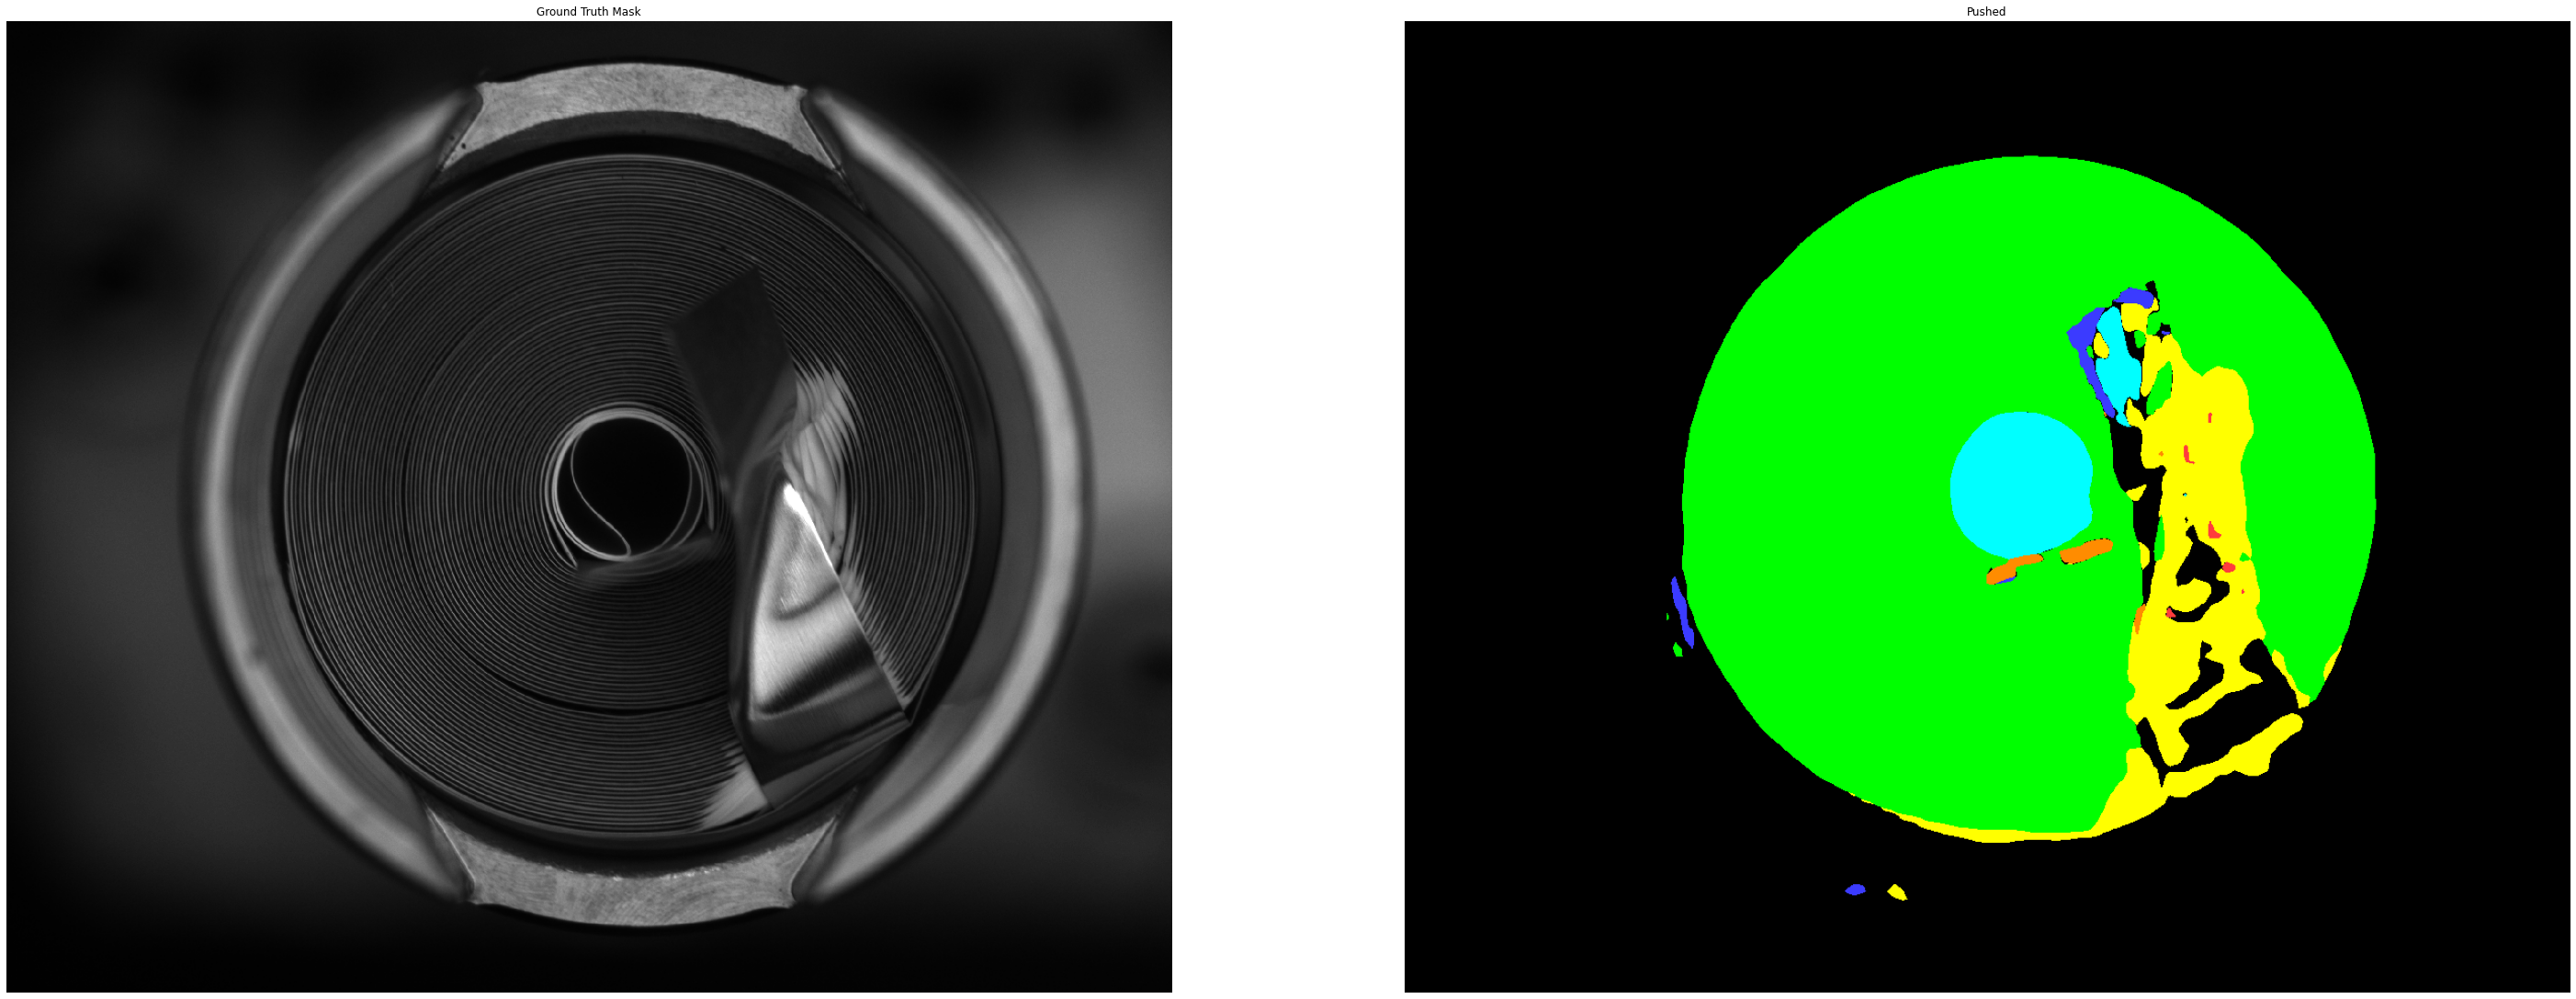

In [195]:
pred = np.float32(pred_mask[idx][0][0])

ex = np.round(pred) # ex = H,W,5
# 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

circle = tf.expand_dims(ex[:,:,1], -1)
pushed = tf.expand_dims(ex[:,:,3], -1) 
bg = tf.expand_dims(ex[:,:,0], -1)
hole = tf.expand_dims(ex[:,:,2], -1)
stamped = tf.expand_dims(ex[:,:,4], -1)
in_tab = tf.expand_dims(ex[:,:,5], -1)
out_tab = tf.expand_dims(ex[:,:,6], -1)
    
    
channel_0 = np.zeros(IMG_SIZE+(1,)) #prediction
channel_1 = np.zeros(IMG_SIZE+(1,))
channel_2 = np.zeros(IMG_SIZE+(1,))

# 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

channel_0[pushed==1] = color_dict[3][0]
channel_1[pushed==1] = color_dict[3][1]
channel_2[pushed==1] = color_dict[3][2]

channel_0[circle==1] = color_dict[1][0]
channel_1[circle==1] = color_dict[1][1]
channel_2[circle==1] = color_dict[1][2]

channel_0[stamped==1] = color_dict[4][0]
channel_1[stamped==1] = color_dict[4][1]
channel_2[stamped==1] = color_dict[4][2]

channel_0[bg==1] = color_dict[0][0]
channel_1[bg==1] = color_dict[0][1]
channel_2[bg==1] = color_dict[0][2]

channel_0[hole==1] = color_dict[2][0]
channel_1[hole==1] = color_dict[2][1]
channel_2[hole==1] = color_dict[2][2]

channel_0[in_tab==1] = color_dict[5][0]
channel_1[in_tab==1] = color_dict[5][1]
channel_2[in_tab==1] = color_dict[5][2]

channel_0[out_tab==1] = color_dict[6][0]
channel_1[out_tab==1] = color_dict[6][1]
channel_2[out_tab==1] = color_dict[6][2]

com = tf.concat([channel_0, channel_1, channel_2], -1)

display([val_x[idx], com],fig_size=50)
#display(com, idx=idx, only_inference=True)
#display([val_x[idx], onehot_to_rgb(val_y[idx]), com],fig_size=50)

In [77]:
"""
idx = 19
gt_mask = np.round(test_y[idx],decimals = 0)
display([tf.image.flip_left_right(tf.image.grayscale_to_rgb(test_x[idx])),tf.image.flip_left_right(onehot_to_rgb(gt_mask))])
"""

'\nidx = 19\ngt_mask = np.round(test_y[idx],decimals = 0)\ndisplay([tf.image.flip_left_right(tf.image.grayscale_to_rgb(test_x[idx])),tf.image.flip_left_right(onehot_to_rgb(gt_mask))])\n'

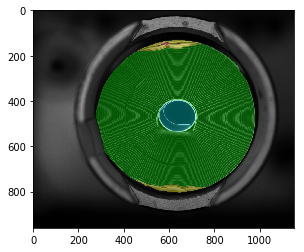

In [416]:
NUM_IMGS = val_x.shape[0]

for idx in range(10):
    img1 = np.array(val_x[idx], np.float64)
    img1 = tf.image.grayscale_to_rgb(tf.convert_to_tensor(img1))
    
    pred = np.float32(pred_mask[idx][0][0])
    ex = np.round(pred) # ex = H,W,5
    # 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

    circle = tf.expand_dims(ex[:,:,1], -1)
    pushed = tf.expand_dims(ex[:,:,3], -1) 
    bg = tf.expand_dims(ex[:,:,0], -1)
    hole = tf.expand_dims(ex[:,:,2], -1)
    stamped = tf.expand_dims(ex[:,:,4], -1)
    
    channel_0 = np.zeros(IMG_SIZE+(1,)) #prediction
    channel_1 = np.zeros(IMG_SIZE+(1,))
    channel_2 = np.zeros(IMG_SIZE+(1,))

    # 0 bg, 1 Circle 2 hole 3 stamp 4 psuhed 

    channel_0[pushed==1] = color_dict[3][0]
    channel_1[pushed==1] = color_dict[3][1]
    channel_2[pushed==1] = color_dict[3][2]

    channel_0[circle==1] = color_dict[1][0]
    channel_1[circle==1] = color_dict[1][1]
    channel_2[circle==1] = color_dict[1][2]

    channel_0[stamped==1] = color_dict[4][0]
    channel_1[stamped==1] = color_dict[4][1]
    channel_2[stamped==1] = color_dict[4][2]

    channel_0[bg==1] = color_dict[0][0]
    channel_1[bg==1] = color_dict[0][1]
    channel_2[bg==1] = color_dict[0][2]

    channel_0[hole==1] = color_dict[2][0]
    channel_1[hole==1] = color_dict[2][1]
    channel_2[hole==1] = color_dict[2][2]

    com = tf.concat([channel_0, channel_1, channel_2], -1)

    img2 = np.array(com, np.float64)
    alpha = 0.7

    #blended = img1 * 0.5  + img2*0.5
    #print(blended.shape)
    blended = cv2.addWeighted(np.array(img1), alpha, img2, (1-alpha), 0) # 방식2
    #blended1 = blended.astype(np.uint8)

    display([blended], idx=idx, loc='test_images/validation/alpha_blended', name='blended', only_inference=True)

#def display(display_list, idx=None, loc='.', name='label', only_inference=False, 
#            fig_size=15, title=['Ground Truth Mask', 'Pushed', 'Stamped'],gray=True):


In [27]:
img1 = np.array(val_x[idx], np.float64)
img2 = np.array(com, np.float64)

alpha = 0.3

#blended = img1 * 0.5  + img2*0.5
#print(blended.shape)
blended = cv2.addWeighted(np.array(img1), alpha, img2, (1-alpha), 0) # 방식2
#blended1 = blended.astype(np.uint8)

display([blended])

error: OpenCV(4.2.0) /io/opencv/modules/core/src/arithm.cpp:669: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


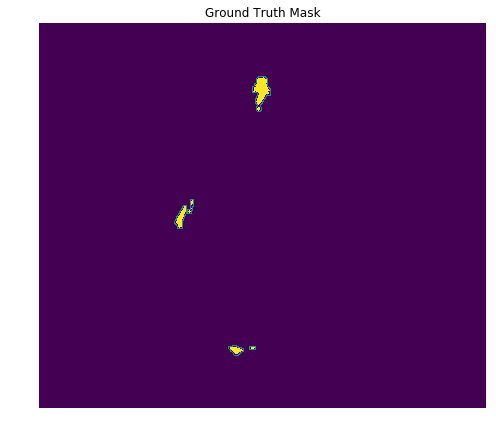

5 stamp found. Area: [197.5, 912.0, 1453.5, 469.5, 3454.0]


In [22]:
stamped_x = np.array(stamped).astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed_stamp = cv2.dilate(stamped_x, k)

contours, hierarchy = cv2.findContours(closed_stamp, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(stamped_x, contours, label="stamp")

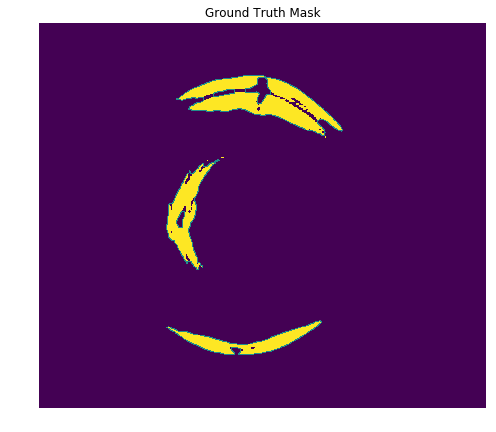

6 push found. Area: [14794.0, 749.0, 19022.5, 852.0, 2848.0, 44040.5]


In [23]:
pushed_x = np.array(pushed).astype(np.uint8) * 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
closing = cv2.morphologyEx(pushed_x, cv2.MORPH_CLOSE, k)

contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img, area, wh, count = draw_and_count(pushed_x, contours, label='push', draw_type='contour')

In [28]:
"""
channel_0 = np.zeros((480,576,1)) #prediction
channel_1 = np.zeros((480,576,1))
channel_2 = np.zeros((480,576,1))

channel_0[pushed==1] = color_dict[1][0]
channel_1[pushed==1] = color_dict[1][1]
channel_2[pushed==1] = color_dict[1][2]

channel_0[circle==1] = color_dict[3][0]
channel_1[circle==1] = color_dict[3][1]
channel_2[circle==1] = color_dict[3][2]

channel_0[stamped==1] = color_dict[2][0]
channel_1[stamped==1] = color_dict[2][1]
channel_2[stamped==1] = color_dict[2][2]

channel_0[bg==1] = color_dict[0][0]
channel_1[bg==1] = color_dict[0][1]
channel_2[bg==1] = color_dict[0][2]

com = tf.concat([channel_0, channel_1, channel_2], -1)


display(com, idx, only_inference=True)
"""

'\nchannel_0 = np.zeros((480,576,1)) #prediction\nchannel_1 = np.zeros((480,576,1))\nchannel_2 = np.zeros((480,576,1))\n\nchannel_0[pushed==1] = color_dict[1][0]\nchannel_1[pushed==1] = color_dict[1][1]\nchannel_2[pushed==1] = color_dict[1][2]\n\nchannel_0[circle==1] = color_dict[3][0]\nchannel_1[circle==1] = color_dict[3][1]\nchannel_2[circle==1] = color_dict[3][2]\n\nchannel_0[stamped==1] = color_dict[2][0]\nchannel_1[stamped==1] = color_dict[2][1]\nchannel_2[stamped==1] = color_dict[2][2]\n\nchannel_0[bg==1] = color_dict[0][0]\nchannel_1[bg==1] = color_dict[0][1]\nchannel_2[bg==1] = color_dict[0][2]\n\ncom = tf.concat([channel_0, channel_1, channel_2], -1)\n\n\ndisplay(com, idx, only_inference=True)\n'

In [21]:
def get_iou(val_y, cls): #0:bg 1:circle 2:hole 3: pressed 4 dent
    iou = []
    fp = []
    fn = []
    tn = []
    tp = []
    
    for idx in range(10):
        ex = np.round(pred_mask[idx][0][0]) # ex = H,W,4

        y_pred = tf.expand_dims(ex[:,:,cls], -1)

        gt_mask = np.round(val_y[idx],decimals = 0)
        if cls not in np.unique(gt_mask): continue
            
        y_true = np.zeros(IMG_SIZE + (1,))
        y_true[gt_mask == cls] = 1
        

        FP = len(np.where(y_pred - y_true  == -1)[0]) #0,1
        FN = len(np.where(y_pred - y_true  == 1)[0]) #1,0
        TP = len(np.where(y_pred + y_true ==2)[0]) #1,1
        TN = len(np.where(y_pred + y_true == 0)[0]) #0,0
        
        cmat = [[TP, FN], [FP, TN]]
        
        if TP+FN+FP == 0 or FN+TP ==0 or FP+TN==0: 
            continue
        
        fp.append(FP)
        fn.append(FN)
        tn.append(TN)
        tp.append(TP)
    
        iou.append (TP/(TP+FN+FP))
        
    
    return ( np.mean(iou), np.mean(fn), np.mean(fp), np.mean(tn), np.mean(tp) )
        
stamp_iou, stamp_fn, stamp_fp, stamp_tn, stamp_tp = get_iou(val_y, cls=4)
pushed_iou, pushed_fn, pushed_fp, pushed_tn, pushed_tp = get_iou(val_y, cls=3)
circle_iou, circle_fn, circle_fp, circle_tn, circle_tp = get_iou(val_y, cls=1)
hole_iou, hole_fn, hole_fp, hole_tn, hole_tp = get_iou(val_y, cls=2)
in_iou, in_fn, in_fp, in_tn, in_tp = get_iou(val_y, cls=5)
out_iou, out_fn, out_fp, out_tn, out_tp = get_iou(val_y, cls=6)

In [22]:
print("STAMP IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(stamp_iou, stamp_fn, stamp_fp, stamp_tn, stamp_tp, 
                                                                               stamp_fn/(stamp_fn+stamp_tp), 
                                                                               stamp_fp/(stamp_fp+stamp_tn)))
print("PUSHED IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(pushed_iou, pushed_fn, pushed_fp,pushed_tn,pushed_tp, 
                                                                                pushed_fn/(pushed_fn+pushed_tp), 
                                                                               pushed_fp/(pushed_fp+pushed_tn)))
print("CIRCLE IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(circle_iou, circle_fn, circle_fp, circle_tn,
                                                                               circle_tp, circle_fn/(circle_fn+circle_tp), 
                                                                               circle_fp/(circle_fp+circle_tn)))
print("HOLE IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(hole_iou, hole_fn, hole_fp, hole_tn,
                                                                               hole_tp, hole_fn/(hole_fn+hole_tp), 
                                                                               hole_fp/(hole_fp+hole_tn)))
print("IN_TAB IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(in_iou, in_fn, in_fp, in_tn,
                                                                               in_tp, in_fn/(in_fn+in_tp), 
                                                                               in_fp/(in_fp+in_tn)))
print("OUT_TAB IoU: {}, FN: {}, FP: {}, TN: {}, TP: {}, FNR: {}, FPR: {}".format(out_iou, out_fn, out_fp, out_tn,
                                                                               out_tp, out_fn/(out_fn+out_tp), 
                                                                               out_fp/(out_fp+out_tn)))

STAMP IoU: 0.27741819973966825, FN: 1242.0, FP: 2800.0, TN: 1100450.5, TP: 1427.5, FNR: 0.46525566585502903, FPR: 0.0025379548887582647
PUSHED IoU: 0.7803993011621715, FN: 6526.142857142857, FP: 3375.0, TN: 1060399.2857142857, TP: 35619.57142857143, FNR: 0.15484712900820283, FPR: 0.003172665522492688
CIRCLE IoU: 0.9807149049836645, FN: 2966.5, FP: 3164.0, TN: 781989.5, TP: 317800.0, FNR: 0.009248160266112576, FPR: 0.004029785258551353
HOLE IoU: 0.9556312500801996, FN: 261.2, FP: 550.1, TN: 1087696.3, TP: 17412.4, FNR: 0.014779105558573237, FPR: 0.0005054921385450942
IN_TAB IoU: 0.7877496568415393, FN: 167.0, FP: 213.7, TN: 1104150.0, TP: 1389.3, FNR: 0.10730578937222901, FPR: 0.0001935050925705001
OUT_TAB IoU: 0.8447661221850158, FN: 168.8, FP: 2302.4, TN: 1089514.4, TP: 13934.4, FNR: 0.011968914856202849, FPR: 0.0021087786888789404
